In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import mapper
import math
from IPython.display import Image
from mapper.mapper_output import fcluster
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial import distance
import warnings
warnings.filterwarnings('ignore')

#set a random seed
np.random.seed(300)

# load the wheel point cloud
wheel = np.genfromtxt('data/wheel.txt', delimiter=' ')

# select random indicies of points in the given cloud
random_indices = np.random.choice(wheel.shape[0], 200)

# select a subset of the point cloud
subcloud = wheel[random_indices, ]

Mapper warning: Could not load the module “fastcluster”.
The module “scipy.cluster.hierarchy“ is used instead, but it will be slower.
The 'cmappertools' module could not be imported.
The 'cmappertools' module could not be imported.
Intrinsic metric is not available.
The 'cmappertools' module could not be imported.


## 3. Mapper for data skeletonization

### 3.1. Brief history of the Mapper success

Mapper is a core product of <a href="https://www.ayasdi.com">Ayasdi</a>, the first start-up co-founded by Prof Gunnar Carlsson in 2008 at Stanford to commercialize Topological Data Analysis. 

Here is the original paper in pdf introducing Mapper : <a href="https://research.math.osu.edu/tgda/mapperPBG.pdf">Topological Methods for the Analysis of High Dimensional Data Sets and 3D Object Recognition</a>.

Mapper has the open-source <a href="http://danifold.net/mapper/index.html">implementation</a> in the Python language, whose visualization part is used below.

Probably the first well-known success of Mapper is a discovery of a new type of breast cancer (c-MYB+ tumors in the picture below) with 100% survival rate (at least during clinical trials), see the <a href="http://www.pnas.org/content/108/17/7265">PNAS paper</a> (2011).

The following skeleton of cancers was produced from only gene data. The long chain of small yellow clusters of new c-MYB+ tumors in the right-hand side branch wasn't identified by past clustering methods, probably because this chain (subgraph) isn't separated from the rest of the data. 

In [2]:
Image(filename='data/img/new-breast-cancer.jpg')

### 3.2. Input and output of the Mapper

In addition to a point cloud, Mapper needs the following information.

1. A filter function $f: C\to{\mathbb R}$ that assigns a real value to every data point;
2. A cover of the image (range) of the filter function $f$ by overlapping intervals;
3. A clustering algorithm (or its parameters) to be applied to several subclouds of $C$.

The code below reminds how one can generate a cloud as a random noisy sample around a circle in the plane. 

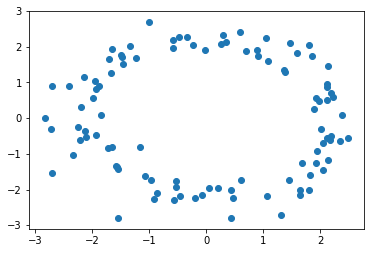

In [3]:
# specify a number of samples
N = 100

# specify a sequence of angles
theta = np.linspace(0, 2*np.pi, N)

# specify a radius
r = np.sqrt(5)

# convert polar coordinates to Euclidean coordinates
x1 = r * np.cos(theta)
y1 = r * np.sin(theta)

# create gaussian noise
mean = np.array([0,0])
cov = np.array([[0.1,0.0],
                [0.0, 0.1]])
noise = np.random.multivariate_normal(mean, cov, N)

# add the noise and create a circle
noisy_circle = np.array((x1+noise[:,0], y1+noise[:,1])).T

plt.scatter(noisy_circle[:,0], noisy_circle[:,1])
plt.show()

### 3.3. A filter function for the Mapper

A filter function plays an essential role in constructing a skeleton or a graph that visualizes the given data. Briefly, a filter function together with a distance between data points helps to cluster a point cloud and then link closely related clusters.

The code below implements the following filter functions 

1. The distance to a base point, which is often (almost) randomly chosen.
2. A measure of centrality ($L_{\infty}$-centrality), which assigns to each point the distance to its farthest neighbor.

In [4]:
def distance_to_base_point(data):
    #choose a random point
    sample_point = data.iloc[np.random.choice(data.shape[0],  1)[0]] 
    # select the furthest point from it
    distances_to_point = (data - sample_point).pow(2).sum(1).pow(0.5)
    # return the distances to the selected base point
    return (data - basepoint).pow(2).sum(1).pow(0.5)


def l_infinity_centrality(data, distance_metric='euclidean'):
    # 
    point_wise_distances = squareform(pdist(data, metric=distance_metric))
    distances = []
    for i in range(len(data)):
        distances.append(np.max(point_wise_distances[i,]))
    return np.array(distances)

For the noisy sample of a circle, we use the projection to the vertical axis (the height function over $C$), hence the $y$-coordinate of every point. The code below prepares all Mapper parameters.

In [5]:
def run_mapper(data, filtered_data, intervals, overlap, hist_cutoff, verbose=0):
    
    data = np.array(data).astype(float)
    cover = mapper.cover.cube_cover_primitive(intervals, overlap)
    cutoff = mapper.cutoff.histogram(hist_cutoff)
    cluster = mapper.single_linkage()
    G = mapper.mapper(data, filtered_data, cover, cutoff, cluster=cluster, verbose=verbose)
    
    return G


### 3.4. The Mapper algorithm step-by-step

The range of a filter function $f:C\to{\mathbb R}$ (the full interval of values from the minimum to the maximum) is usually split into a given number $k$ of subintervals (typically with 50% overlap between successive subintervals). This number $k$ is an essential parameter of the Mapper and also is a lower bound for the number of nodes in a final graph.

Here are the basic steps of the Mapper algorithm.

1. For each subinterval $I_j$, $j=1,\dots, k$, in the range of the filter function $f$, select the subcloud $S_j=f^{-1}(I_j)\subset C$ consisting of all points $p\in C$ such that $f(p)\in I_j$.
2. Cluster each subcloud $S_j$, $j=1,\dots, k$, according to a given clustering algorithm.
3. For every cluster within $S_j$, assign a node (an isolated vertex) of the Mapper graph $G$.
4. Connect two nodes of $G$ by a link if the corresponding clusters share common points of $C$.

Due to the subintervals $I_j$, the filter function $f$ can be visualised (for any cloud $C$ in a high-dimensional space) through the histogram that counts the numbers of points in the subclouds $S_j=f^{-1}(I_j)\subset C$.

In [18]:
def test_filter(f, interval, overlap):
    from matplotlib.pyplot import cm 
    
    # set up mapper sub
    cover = mapper.cover.cube_cover_primitive(interval, overlap)
    
    # set up matplotlib Axes
    f1, ax1 = plt.subplots(1, figsize=(6, 6))
    
    # set up colors
    color=iter(cm.rainbow(np.linspace(0,1,interval)))
    
    # draw filter function histogram
    ax1.hist(f)

    # draw in the same color the beginning and end 
    # for each subinterval in the range of the filter function
    for subinterval in cover(f):
        c = next(color)
        ax1.axvline(x=subinterval.range_min, color=c)
        ax1.axvline(x=subinterval.range_max, color=c)

    plt.show()

The code below shows the histogram of the $y$-projection over the circle. All bins (subclouds) are not empty. The subclouds with low and high values (of $y$-coordinates) are larger than subclouds with mid-values. 

The histogram below implies that the filter function well separates the given data. If the majority of data points was in only one bin, then the output of Mapper wouldn't differ too much from traditional clustering.

In [19]:
test_filter(noisy_circle[:,1], 5, 40)

The following code evaluates the quality of a filter function by showing how subclouds $S_j$ are clustered based on the cutoff function as implemented by the original Mapper paper in 2008. 

In [20]:
def test_mapper_configuration(data, fd, interval, overlap, bins):

    # set up mapper functions
    cover = mapper.cover.cube_cover_primitive(interval, overlap)
    cutoff = mapper.cutoff.histogram(bins)
    data = np.array(data).astype(float)
    
    for subinterval in cover(fd):
        
        # get the indecies of the data that fall within this subinterval
        lb = fd >= subinterval.range_min
        ub = fd <= subinterval.range_max
        indxs = np.logical_and(lb, ub)
        
        print (subinterval)
        print('Number of points in level -', sum(indxs))
        
        # get the subcloud
        part_data = pdist(data[indxs,:])
        
        # get the biggest distance between points in the subcloud
        R = part_data.max()
        
        # compute the minimum spanning tree using single edge clustering
        Z = linkage(part_data)
        
        # get the heights
        heights = Z[:,2]
        
        # calculate the first empty bin in the histogram using the mapper function
        num_clust = cutoff(heights, R)
        
        # calculate the bins manually for plotting
        bin_counts, bin_leftedges = np.histogram(heights,
                                                 bins=bins,
                                                 range=(0,R))        
        #create matplotlib axes
        f1, ax1 = plt.subplots(1, figsize=(6, 6))
        
        #plot the distribution of the edge lengths in the bins
        ax1.bar(bin_leftedges[:-1] + np.diff(bin_leftedges) / 2, bin_counts, np.diff(bin_leftedges))
        
        #plot the bins the algorithm uses to make the cutoff choice
        for edge in bin_leftedges:
            ax1.axvline(x=edge, color='r')
        
        print('Clusters - ', num_clust)
        plt.show()

After putting all points of each subcloud $S_j$ into a fixed number of bins, we group adjacent non-empty bins into a single cluster.

Hence any empty bin in a histogram below separates clusters (if any) on the left and on the right.

Filter level. Index: (0,), Range min: [-2.80816765], Range max: [-1.18814872]
Number of points in level - 31
Clusters -  1


Filter level. Index: (1,), Range min: [-1.83615629], Range max: [-0.21613737]
Number of points in level - 32
Clusters -  1


Filter level. Index: (2,), Range min: [-0.86414494], Range max: [0.75587399]
Number of points in level - 27
Clusters -  2


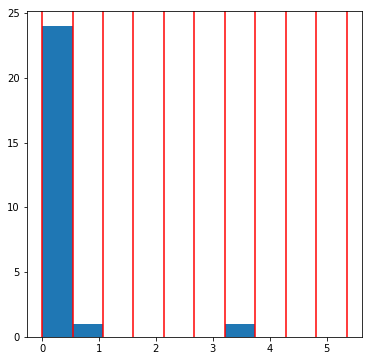

Filter level. Index: (3,), Range min: [0.10786642], Range max: [1.72788535]
Number of points in level - 26
Clusters -  2


Filter level. Index: (4,), Range min: [1.07987778], Range max: [2.69989671]
Number of points in level - 31
Clusters -  1


In [21]:
test_mapper_configuration(noisy_circle, noisy_circle[:,1], 5, 40, 10)

The following code shows subclouds $S_j=f^{-1}(I_j)\subset C$ in different colors. Some points belong to two subclouds and are shown as "double stars in our universe" (doubly colored disks).

In [23]:
def color_circle(data, f, interval, overlap, ax):
    from matplotlib.pyplot import cm 
    
    # initialize the cover and colors
    cover = mapper.cover.cube_cover_primitive(interval, overlap)
    color = iter(cm.rainbow(np.linspace(0,1,interval)))
    
    # an array that moves the points a little bit to the right or left
    shakeup = [((-1)**i) * 0.02 for i,_ in enumerate(cover(f))]
    
    for i, subinterval in enumerate(cover(f)):
        
        # get the indecies of the data that fall within this subinterval
        lb = f >= subinterval.range_min
        ub = f <= subinterval.range_max
        indxs = np.logical_and(lb, ub)
        
        # get the next color
        c = next(color)
        
        # plot the subcloud
        ax.scatter(data[indxs][:,0]+shakeup[i], 
                    data[indxs][:,1], color=c, alpha=0.8)
        
    return plt.show()

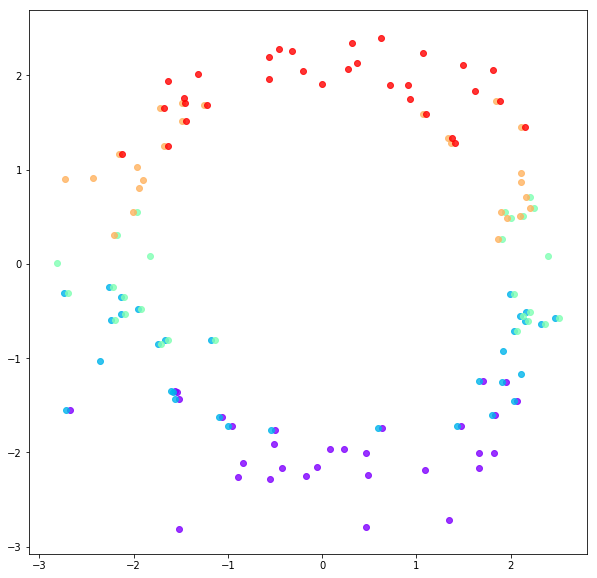

In [24]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
_ = color_circle(noisy_circle, noisy_circle[:,1], 5, 40, ax)

### 3.5. The Mapper output is an abstract graph

The code below calls the Mapper and draws the resulting graph as a network with 7 interlinked nodes. 

In [12]:
def run_mapper(data, filtered_data, intervals, overlap, hist_cutoff, verbose=0):    
    
    data = np.array(data).astype(float)
    cover = mapper.cover.cube_cover_primitive(intervals, overlap)
    cutoff = mapper.cutoff.histogram(hist_cutoff)
    cluster = mapper.single_linkage()
    G = mapper.mapper(data, filtered_data, cover, cutoff, cluster=cluster, verbose=verbose)
    return G

There are 7 nodes.


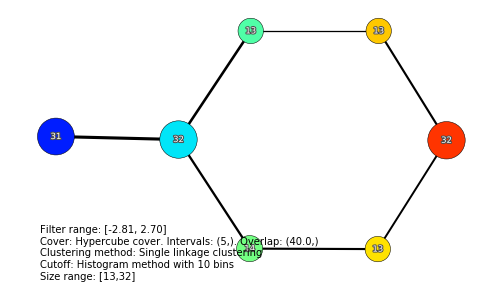

In [13]:
G = run_mapper(noisy_circle, noisy_circle[:,1], 5, 40, 10, verbose=0)
_ = G.draw_2D()

Each node of the Mapper graph represents (and shows the number of points from~) a cluster in a subcloud of the given data. 

The colors of the nodes above reflect the filter function: the blue color corresponds to clusters with low values, the red color highlights clusters with high values. 

For suitable parameters and a filter function, the Mapper algorithm can sometimes "understand" the topological shape of a cloud sampled from the wheel graph earlier by finding "4 big cycles", though the output may contain too many nodes.

In [14]:
import operator

def leftmost_filter(data):
    leftmost_index, _ = min(enumerate(data[::, 0]), key=operator.itemgetter(1))
    return np.sqrt(np.sum(np.power(data - data[leftmost_index], 2), axis=1))

G = run_mapper(subcloud, leftmost_filter(subcloud),
               10, 30, 25, verbose=0)

There are 27 nodes.


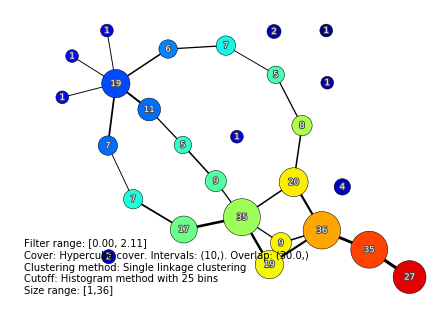

In [15]:
_ = G.draw_2D()

Filter functions can also be two dimensional or higher. Additionally, the covers can be more complicated than simple overlaps.

In [16]:
G = run_mapper(subcloud, subcloud, 7, 40, 7, verbose=0)

There are 70 nodes.


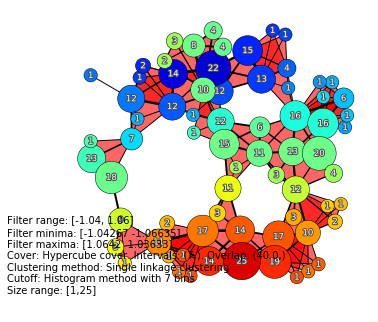

In [17]:
_ = G.draw_2D()

The key advantage of the Mapper approach over traditional clustering is a higher level representation where clusters are linked in a data-driven way. Since any graph can be drawn without intersections in a 3-dimensional space, such a 1-dimensional graph or a network can easily visualize any high-dimensional data. 

However, the Mapper has many parameters that can be hard to tune for real data (when an expected topological shape is unknown). Moreover, the Mapper graph is abstract and doesn't show cycles or links directly in the given data space. 

The second half of the tutorial discusses another topological skeleton, which overcomes the disadvantages above.